## Aligning Reads to the Human Reference Genome

The genome of a strain of *Shewanella oneidensis* (a metal reducing bacterium) was sequenced on Illumina MiSeq. Knowing that the run was likely contaminated with human DNA, the sequence data was aligned with a human genome, and any aligned reads were thrown out.

Bowtie2 was run with the command ```bowtie2 -p 4 --very-fast --no-unal -x /data/hg19/hg19 -U /data/lab6/illumina_reads.fastq -S /home/be131-04/contaminants_human.sam --un /home/be131-04/clean_Shewanella.fastq```  

**The Flags:**  
```-p 4``` is for using 4 cpu cores  
```--very-fast``` controls tradeoff between speed and sensitivity. Because *Shewanella oneidensis* and humans diverged a long time ago, their sequences are very different, so sensitivity wasn't prioritized.  
```--no-unal``` removes unaligned reads from the main SAM file as a space-saving measure  
```-x /path/to/ref/genome``` the human genome database that the reads were aligned to    
```-U path/to/input/reads``` the sequencing results, in FASTQ format  
```-S path/to/output/file``` the output SAM file. Any reads here were aligned with the human reference genome, so they are contaminants    
```--un path/to/unaligned/reads``` FASTQ file of all the unaligned reads. Represents the clean bacteria reads.  

#### Human Genome Alignment - Terminal Output

1124714 reads; of these:  
  1124714 (100.00%) were unpaired; of these:  
    1028379 (91.43%) aligned 0 times  
    87274 (7.76%) aligned exactly 1 time  
    9061 (0.81%) aligned >1 times  
8.57% overall alignment rate  


Roughly 8% of the sequencing data came from contaminated human DNA.

## Aligning Reads to the *S. oneidensis* Reference Genome

To determine how well the sample of *S. oneidensis* was sequenced, the clean_Shewanella.fastq file was aligned with a *S. oneidensis* reference genome, again using Bowtie2. The command provided was ```bowtie2 -p 4 --very-sensitive --no-unal -x /data/lab6/shewanella_oneidensis_mr-1 -U clean_Shewanella.fastq -S S_oneidensis_aligned.sam --un contaminants_unknown.fastq```  

#### *S. oneidensis* Genome Alignment - Terminal Output

1028379 reads; of these:  
  1028379 (100.00%) were unpaired; of these:  
    298112 (28.99%) aligned 0 times  
    688180 (66.92%) aligned exactly 1 time  
    42087 (4.09%) aligned >1 times  
71.01% overall alignment rate  

The unaligned FASTQ file contains all reads that could not be matched to any part of the reference genome. These are likely lower quality sequencing reads, or possibly mutations/alternate alleles in the sequenced bacteria.  

If the exact same command is run with the ```--very-fast``` flag, the output is the following:  

1028379 reads; of these:  
  1028379 (100.00%) were unpaired; of these:  
    299560 (29.13%) aligned 0 times  
    687571 (66.86%) aligned exactly 1 time  
    41248 (4.01%) aligned >1 times  
70.87% overall alignment rate  

There is about a 1% difference in the number of reads aligned, a negligible amount.

## Generating a Coverage Plot for *S. oneidensis*

After aligning the reads to the *S. oneidensis* reference genome, the S_oneidensis_aligned.sam file was converted into a bamfile by passing the command ```samtools view -b S_oneidensis_aligned.sam > S_oneidensis_aligned.bam``` to Samtools. The data was then sorted and indexed using ```samtools sort S_oneidensis_aligned.bam > S_oneidensis_aligned.sorted.bam``` and ```samtools index S_oneidensis_aligned.sorted.bam```, respectively.  

To determine the depth of coverage for every position in the reference genome, the sorted and indexed bamfile was again run through Samtools with the command ```samtools depth S_oneidensis_aligned.sorted.bam > S_oneidensis_pileup.tab```  

It was determined from the S_oneidensis_pileup.tab file that the maximum coverage was 269 reads, the minimum coverage (for a region that had coverage) was 1 read, and the average coverage over all the regions was 36.95 reads.

In [19]:
#calculate min, max, and mean coverage depth
import numpy as np

print("min: " + str(min(coverage_per_position)))
print("max: " + str(max(coverage_per_position)))
print("mean: " + str(np.mean(coverage_per_position)))

min: 1
max: 269
mean: 36.95638840970833


In [4]:
#extract the coverage depth for each position from the S_oneidensis_pileup.tab file
%matplotlib inline
import matplotlib.pyplot as plt

f = open("S_oneidensis_pileup.tab")
data = f.readlines()

positions_in_genome = []
coverage_per_position = []

for line in data:
    line = line.split() #splits on whitespace characters
    positions_in_genome.append(int(line[1]))  #position in genome in column 1 of file (ignoring ID in column 0)
    coverage_per_position.append(int(line[2]))  #number of times position was covered in column 2 of file

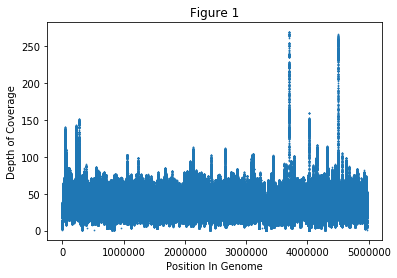

In [20]:
#Scatter Plot of coverage depth per run
plt.scatter(x = positions_in_genome,
           y = coverage_per_position,
           s = 0.5)
plt.xlabel("Position In Genome")
plt.ylabel("Depth of Coverage")
plt.title("Figure 1")
plt.show()

There are several regions in the *S. oneidensis* sample genome that had remarkably high coverage, notably around the 3,750,000 and 4,500,000 positions. Because these data only include regions with at least 1X coverage, it is not possible to determine which regions had no coverage.

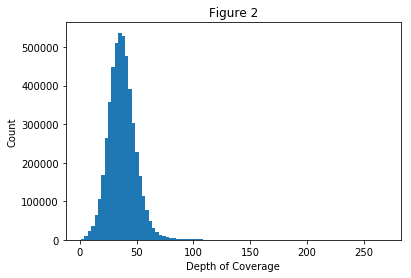

In [24]:
#Histogram of coverage depth per run
plt.hist(coverage_per_position, bins = 90)
plt.xlabel("Depth of Coverage")
plt.ylabel("Count")
plt.title("Figure 2")
plt.show()

The vast majority of positions in the *S. oneidensis* genome sequence fall in the 25X-50X coverage range. Consistent with the scatter plot in **Figure 1**, there are a few outlier positions with nearly 250X coverage.

## Generating a Coverage Plot for *H. sapiens*

Coverage plots were also generated for the contaminant DNA filtered from the sequencing reads. The process was largely the same as it was for generating coverage plots for *S. oneidensis*. The commands used were as follows:

Converting the alignment file into a bamfile: ```samtools view -b contaminants_human.sam > contaminants_human.bam```    

Sorting and indexing the data: ```samtools sort contaminants_human.bam > contaminants_human.sorted.bam``` and ```samtools index contaminants_human.sorted.bam```, respectively.  

Determining the depth of coverage for every position in the reference genome: ```samtools depth contaminants_human.sorted.bam > human_pileup.tab```  

Average coverage depth for each chromosome was calculated by summing the total number of reads per chromosome and dividing that by the "assembled molecule" chromosome length, as given by the information for hg19 on the NCBI website.

Chromosomal reads that could not be matched to a known chromosome, or contained ```_random``` in their IDs were ignored.

Due to the presence of reads on the Y chromosome, Jamie is likely to be biologically male.

In [29]:
#extract the coverage depth for each chromosome from the human_pileup.tab file
f = open("human_pileup.tab")
data = f.readlines()

cov_per_chrom = {}

for line in data:
    line = line.split()
    chr_num = line[0]
    if chr_num in cov_per_chrom:
        cov_per_chrom[chr_num] += int(line[2])
    else:
        cov_per_chrom[chr_num] = int(line[2]) #number of times position was covered in column 2 of file

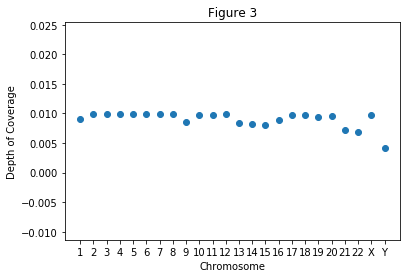

In [43]:
avg_cov_depth = [cov_per_chrom['chr1']/249250621, cov_per_chrom['chr2']/243199373, cov_per_chrom['chr3']/198022430, 
                cov_per_chrom['chr4']/191154276, cov_per_chrom['chr5']/180915260, cov_per_chrom['chr6']/171115067, 
                cov_per_chrom['chr7']/159138663, cov_per_chrom['chr8']/146364022, cov_per_chrom['chr9']/141213431, 
                cov_per_chrom['chr10']/135534747, cov_per_chrom['chr11']/135006516, cov_per_chrom['chr12']/133851895,
                cov_per_chrom['chr13']/115169878, cov_per_chrom['chr14']/107349540, cov_per_chrom['chr15']/102531392, 
                cov_per_chrom['chr16']/90354753, cov_per_chrom['chr17']/81195210, cov_per_chrom['chr18']/78077248, 
                cov_per_chrom['chr19']/59128983, cov_per_chrom['chr20']/63025520, cov_per_chrom['chr21']/48129895, 
                cov_per_chrom['chr22']/51304566, cov_per_chrom['chrX']/155270560, cov_per_chrom['chrY']/59373566]

chr_nums = [str(x+1) for x in range(22)]
chr_nums.append('X')
chr_nums.append('Y')
    
    
#Scatter Plot of human coverage depth per run
plt.scatter(x = chr_nums,
           y = avg_cov_depth)
plt.xlabel("Chromosome")
plt.ylabel("Depth of Coverage")
plt.title("Figure 3")
plt.show()

For each chromosome, the average depth of coverage was roughly 0.01X. This makes sense because the human DNA was a contaminant, one which was present in far lower concentrations than the actual sample.

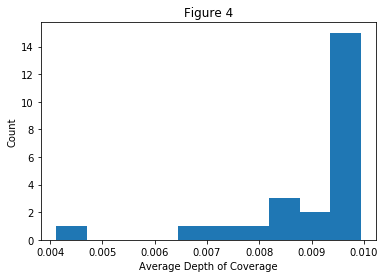

In [47]:
#Histogram of human coverage depth per run
    
plt.hist(avg_cov_depth)
plt.xlabel("Average Depth of Coverage")
plt.ylabel("Count")
plt.title("Figure 4")
plt.show()

All chromosomes in the contaminant human genome sequence fall in the very low average coverage range, consistent with the scatter plot in **Figure 3**. In fact, no chromosome had more than 0.01X coverage.

In [ ]:
#Zoom in on very high coverage regions

"""
There are two really high peaks, so I'll find out what genome positions those two really high peaks are at. 
I'll then use that info to find out what genes are at those positions in S. oneidensis (either from the fasta file or 
from google) and BLAST them to find out what they are

this bitch has a single circular chromosome, so we can just search the .bam/.sam file by position using samtools view
to find out what read belongs to that position
"""

max_index = coverage_per_position.index(max(coverage_per_position))
max_genome_pos = positions_in_genome(max_index)
del coverage_per_position[max_index]
del positions_in_genome[max_index]


max2_index = coverage_per_position.index(max(coverage_per_position))
max2_genome_pos = positions_in_genome(max_index)


**Note:** I didn't have time to finish the high coverage region extra credit section, but I'm leaving it here for reference in case I have to solve
a similar problem in the future.